TUTORIAL 3 : RDF
================

Original author: Andrey V. Brukhno (andrey.brukhno{at}stfc.ac.uk)

Modified to use dlmontepython by Joe Manning (joseph.manning{at}manchester.ac.uk)


Radial Distribution Function
----------------------------

Consider a system of identical particles (atoms or molecules) at constant *N,V,T* (canonical ensemble). 

The **Radial Distribution Function**, or *pair distribution function, g(r),* describes the average density variation as a function of separation between any two particles. 

<img src="images/RDF-illustrations-med.png" alt="Demonstration of the Metropolis algorithm" class="bg-primary" width="500px"> 

To arrive at the expression for *g(r)*, we first consider the *n*-particle density distribution, which is proportional to the probablity of a *particular n*-particle configuration (${\mathbf r}_1, \dots, {\mathbf r}_n$):


$$
   \rho^{(n)}( {\mathbf r}_1, \dots, {\mathbf r}_n ) = 
   \frac{N!}{(N-n)!} \int \frac{\exp[-\beta U(\mathbf r^{N})]}{Z(N,V,T)} \ d{\mathbf r}_{n+1} \dots d{\mathbf r}_N
$$

where the *N! / (N-n)!* factor accounts for all relevant permutations (due to the particles being identical); and *Z(N,V,T)* is the canonical partition function (normalisation constant in *NVT* ensemble). Setting *n* = 2 one can define the *normalised* pair distribution function

$$
   g({\mathbf r}_1, {\mathbf r}_2) = 
   \frac{ \rho^{(2)}({\mathbf r}_1, {\mathbf r}_2) }{ \rho^{(1)}({\mathbf r}_1) \rho^{(1)}({\mathbf r}_2) } =
   \frac{V^2(N-1)}{N} \int \frac{\exp[-\beta U(\mathbf r^{N})]}{Z(N,V,T)} \ d{\mathbf r}_{3} \dots d{\mathbf r}_N
$$

For an isotropic system of spherical particles one can simplify the latter formula by recognising that the *radial distribution function* depends only on the particle separation and should also be normalised by the area of the sphere of radius *r* drawn around a reference particle ("entropy on a sphere"):

$$
   g(r)dr = \frac{V}{4\pi r^2 N^2} \langle \sum_{i\ne j} \delta(|\Delta\mathbf r_{ij}|-r) \rangle
   g(r)dr = \frac{\rho^{(2)}(r)}{4\pi r^2 \rho_{b}} = \frac{V(N-1)}{4\pi r^2 N} \sum_{i\ne j}\int \delta(|\mathbf r_i - \mathbf r_j|-r) \frac{\exp[-\beta U(\mathbf r^{N})]}{Z(N,V,T)} \ d\mathbf r^{N}
$$
so that $\rho(r)/\rho_b = g(r\to\infty)\to 1$, whereas $\rho_b g(r)$ gives the local density at distance $r$ away from a particle.

$$
    \rho_b \int g(r) 4\pi r^2dr = N-1
$$

NOTE: in simulation RDF can only be determined up to $r_{\rm max} = \frac{1}{2} \min({\rm cell\ dimensions})$

<img src="images/RDF-e1s1t12-s.png" alt="Demonstration of the Metropolis algorithm" class="bg-primary" width="500px"> 

### Potential of mean force (PMF)


Potential of mean force (PMF or POMF) is defined as the work done upon reversibly bringing two particles from the state of zero-interaction into the state of full-interaction at a given distance, *W(r)*. 

PMF can be directly obtained from RDF:

$$
   \beta W(r) = -\ln g(r) + \ln g(\infty)
$$
where the zero-interaction state corresponds to infinite separation $(r\to\infty)$.

NOTE: The PMF concept is also applicable to molecules, complexes or aggregates in solution.

Exercise 3.1 - RDF calculation
------------------------------

The exercises are based on [tutorial_2](), developing it somewhat further.

We'll read in the appropriate files from the tutorial 2 directory to memory and modiy them here:

In [6]:
from dlmontepython.htk.sources import dlcontrol, dlconfig, dlfield

config = dlconfig.CONFIG.from_file('./tutorial_2_simulation/CONFIG')

field = dlfield.from_file('./tutorial_2_simulation/FIELD')

control = dlcontrol.CONTROL.from_file('./tutorial_2_simulation/CONTROL')
control.title = 'RDF example'


Below the essential amendments in CONTROL and FIELD files for this tutorial are described.

We use reduced energy units, i.e. kT, whence Kelvin is set as energy unit in FIELD file:

```
   UNITS K
```

The VDW parameters are in the units of kT and Angstrom):

```
   VDW 1
   LJ core  LJ core lj   1.0 1.0 
```

In [10]:
field.description = 'Lennard-Jones, 2.5*sigma cut-off, sigma = 1 Angstrom, epsilon = 1 K'
field.units = 'K'
field.vdw = [dlfield.VDW.from_string(' LJ core  LJ core lj   1.0 1.0 ')]
field

FIELD(description='Lennard-Jones, 2.5*sigma cut-off, sigma = 1 Angstrom, epsilon = 1 K', cutoff=2.5, units='K', nconfigs=1, atomtypes=[AtomType(name= 'LJ', type= 'core', mass= 1.0, charge= 0.0)], moltypes=[MolType(name='lj', nmaxatom=512, atoms=[], bonds=[], exc_coul_ints=False, rigid= False)], vdw=[VDW(atom1=Atom(name= 'LJ', type= 'core'), atom2=Atom(name= 'LJ', type= 'core'), interaction=Interaction(key='lj', type='Lennard-Jones', epsilon=1.0, sigma=1.0))], bonds2body=[], angles3body=[])

In CONTROL file reduced temperature is set below the critical point and pressure slightly over the critical value (note that pressure is always set in katm):

```
   temperature     1.0             # Reduced temperature T* = 1.0 < T*(CP) = 1.1876
   pressure        0.02            # p* = p(katm)/0.163882576 > p*(CP)=0.1093 (reduced pressure at CP)
```

Collection of RDF data is invoked with the following directive in CONTROL file:

```
   sample rdf <int> <float> <int>
```

where the three parameters are:

* **number of grid points (bins)** - set to a multiple of 10 (500)

* **cutoff** - set to half the (expected) minimum cell dimension (5.0)

* **stride (number of MC steps)** for accumulation of RDF samples - set to 1000

We also invoke collection of data for volume evolution and probability distribution, *P(V)*, with the following line:

```
   sample volume <int> <float>
```
where the two parameters are:

* **stride (number of volume steps)** for accumulation of samples - set to 10

* **bin size** - set to 10.0

Now you can re-run the *NpT* calculation for LJ system. Verify that RDFDAT.000 file has been created as a result. Note that RDFDAT file(s) are updated each time the stats are periodically saved, so one can check RDF data while the simulation is still being executed.

In [19]:
from collections import OrderedDict
control.temperature = 1
control.pressure = 0.02
control.main_block.samples['rdf'] = OrderedDict([('ngrid', 500), ('cutoff',5.), ('stride', 1000)])
control

CONTROL(title= 'RDF example', use_block= UseBlock(use_statements= OrderedDict([('ortho', None)]), fed_block= None), main_block= MainBlock(statements= OrderedDict([('seeds', OrderedDict([('seed0', 12), ('seed1', 34), ('seed2', 56), ('seed3', 78)])), ('nbrlist', 'auto'), ('maxnonbondnbrs', 512), ('temperature', 1), ('pressure', 0.02), ('steps', 110000), ('equilibration', 10000), ('print', 10000), ('stack', 10000), ('yamldata', 1000), ('revconformat', 'dlmonte'), ('archiveformat', 'dlpoly4')]), moves= [AtomMove(pfreq= 512, movers= [{'id': 'LJ core'}]), VolumeCubicMove(pfreq= 1, sampling= 'linear')], samples= OrderedDict([('coords', OrderedDict([('nfreq', 10000)])), ('volume', OrderedDict([('mfreq', 1), ('deltav', 1.0)])), ('rdf', OrderedDict([('ngrid', 500), ('cutoff', 5.0), ('stride', 1000)]))])))

Now that the files have been loaded into memory and modified, you can write them to a new simulation directory

In [21]:
import os
try:
    os.mkdir('./tutorial_3_simulation/')
except FileExistsError:
    pass

with open('./tutorial_3_simulation/CONTROL', 'w') as f:
    f.write(str(control))

with open('./tutorial_3_simulation/FIELD', 'w') as f:
    f.write(str(field))

with open('./tutorial_3_simulation/CONFIG', 'w') as f:
    f.write(str(config))

## Data analysis

From the simulation, we can now import the RDF file and compare against the folowing example:


<img src="images/Ex2-gnuplot-RDF-equil1.png" alt="Demonstration of the Metropolis algorithm" class="bg-primary" width="500px"> 

<AxesSubplot:xlabel='Radius (A)'>

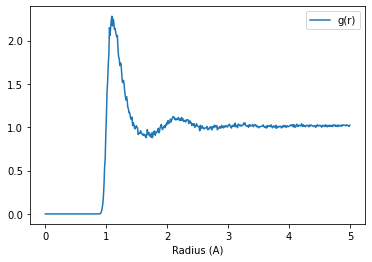

In [64]:
import matplotlib.pyplot as plt
import pandas as pd

rdf = pd.read_csv('./tutorial_3_simulation/RDFDAT.000',  # reading in from the file
                  sep = ' ', # column sepaator, which is some amount of spaces
                  skiprows=7, # 7 lines of informaiton above first data point
                  header=None,
                 skipinitialspace=True) # No column titles specified in file)


rdf = rdf.dropna(how='all', axis=1) # Drop any columns with no data in
rdf = rdf.rename({0: 'Radius (A)', 1: 'g(r)', 2: 'Sum data'}, axis=1) # Manually specifying the column titles
rdf = rdf.set_index('Radius (A)') # Set the index to be the first column
rdf.plot(y='g(r)') #plot!

### Checking the RDF

Questions to answer:

* Does it look reasonable?
* Any artifact observed?

You can check if the simulation converged with respect to volume (density) variations::

<img src="images/Ex2-gnuplot-Volume-equil1.png" alt="Demonstration of the Metropolis algorithm" class="bg-primary" width="500px"> 

You can also check the probability distribution for volume, *P(V)*::

<img src="images/Ex2-gnuplot-Vprob-equil1.png" alt="Demonstration of the Metropolis algorithm" class="bg-primary" width="500px"> 


<AxesSubplot:>

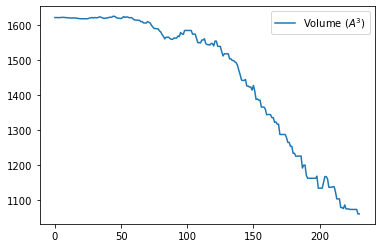

In [40]:
volume = pd.read_csv('./tutorial_3_simulation/VOLDAT.000', header=None, names=["Volume ($A^3$)"])
volume.plot(y="Volume ($A^3$)")

<AxesSubplot:xlabel='Volume ($A^3$)'>

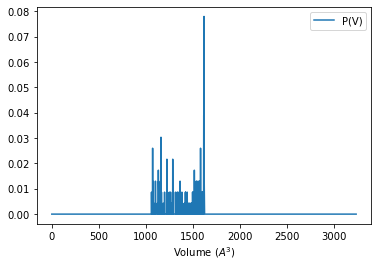

In [61]:
volume_probability = pd.read_csv('./tutorial_3_simulation/NPTDAT.000',
                                header=None,
                                skiprows=5,
                                sep=' ',
                                skipinitialspace=True)
volume_probability = volume_probability.dropna(how='all', axis=1)
volume_probability = volume_probability.rename({0: 'Volume ($A^3$)', 1: 'P(V)'}, axis=1)
volume_probability = volume_probability.set_index('Volume ($A^3$)')
volume_probability.plot()

#### What might go wrong?


Questions to answer:

* Has the simulation converged w.r.t. to volume?
* Are the collected statistics sufficient (noisy data, large errors)?

### Performing an additional run
You might need to perform an additional run, restarting the simulation with the latest configuration stored in REVCON file.

Let's do this in a new directory, so as not to lose any of our existing data. We'll not be changing the FIELD file, so let's print it there as-is.

In [66]:
import os
try:
    os.mkdir('./tutorial_3_equil_2/')
except FileExistsError:
    pass

with open('./tutorial_3_equil_2/FIELD', 'w') as f:
    f.write(str(field))



We want to use a different config though - the REVCON file from the intial simulation:

In [67]:
restart = dlconfig.CONFIG.from_file('./tutorial_3_simulation/REVCON.000')
with open('./tutorial_3_equil_2/CONFIG', 'w') as f:
    f.write(str(restart))

Based on what we learnt from the equilibration run, some amendments are necessary in CONTROL file:

```
   steps          10000000         # Number of moves to perform in simulation 
   equilibration      1000         # Equilibration period: statistics are gathered after this period
   sample coordinate 10000         # Frequency to output configuration to trajectory file(s)
   sample volume  10  2.           # Sample volume: every 10th volume move (on average); bin size
   sample rdf 450 4.5 1000         # Sample RDF(s): number of bins; cutoff; stride (number of steps)
```

In [71]:
from copy import deepcopy
new_control = deepcopy(control)

new_control.steps = 1e7
new_control.equilibration = 1e3
new_control.main_block.samples['coords']['nfreq'] = 1e4
new_control.main_block.samples['volume']['mfreq'] = 10
new_control.main_block.samples['volume']['deltav'] = 2.
new_control.main_block.samples['rdf']['ngrid'] = 450
new_control.main_block.samples['rdf']['curoff'] = 4.50


with open('./tutorial_3_equil_2/CONTROL', 'w') as f:
    f.write(str(new_control))

#### Checking the results
Go through the data analysis as before - does this look more converged?

## Lowering density

In order to see the effect on RDF let us increase temperature (thereby, aiming at lower density). 
Edit CONTROL file again: 

```
   temperature     1.5            # Reduced temperature T* = 1.5 > T*(CP) = 1.1876
   pressure        0.02           # p* = p(katm)/0.163882576 > p*(CP)=0.1093 (reduced pressure at CP)
   sample rdf 400 8.0 1000
   sample volume 10 10.
```

re-run the simulation and redo the analysis.

Again store away the current results in **equil-rdf2** in case you may need to redo or restart this simulation!

Consider adding the following directives in CONTROL:

```
   maxatmdist           5.0        # initial max atom displacement (set based on equilibration run)
   acceptatmmoveupdate  1000       # stride (number of MC steps) for adjusting the max atom displacement
   acceptatmmoveratio   0.4        # target acceptance ratio for atom moves [default: 0.37]
```
After the production run and analisys, store away the results in a new directory **prod-rdf2**::

Exercise 3.2 - PMF calculation
------------------------------

Calculate the PMFs corresponding to the RDFs obtained above using the pandas `apply` function

<img src="images/Ex2-gnuplot-PMF-prod2.png" alt="Demonstration of the Metropolis algorithm" class="bg-primary" width="500px"> 


TypeError: 'list' object is not callable

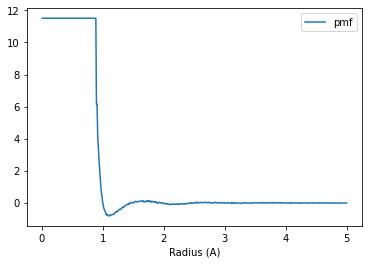

In [79]:
import numpy as np
rdf['pmf'] = rdf['g(r)'].apply(lambda x: -np.log(x+1e-5))
rdf.plot(y='pmf')
plt.xrange([-1,4])
plt.show()